# Atlas ESCP 

In [1]:
# CrossCompute
user_address = ""
search_radius_in_miles = 0.5
industry_select = """
    Manufacturing

    Manufacturing
    Wholesale/Warehouse/Distribution
    Commercial
    Landlord
    Public Benefit Corp
    Other
"""
program_select = """
    ICIP
    
    ICIP
    ICAP
    City/State
    IDA
    Relocator
    Tenant
"""
target_folder = '/tmp'

In [2]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR


import subprocess
subprocess.call('pip install geopandas'.split())
subprocess.call('pip install dill'.split())

matplotlib.rcParams['figure.figsize'] = (10,10)

## Prepare building dataset

<font color=blue>__Tasks: <br><br> 1. Feature selection: Drop information users don't care about. <br> 2. Smooth out time factor by calculating "Periodic Savings over months" starting from effective date (round to month) to 2017-12-31__

In [3]:
# Prepare builing data
url1 = 'https://data.cityofnewyork.us/api/views/ukdt-xm28/rows.csv?accessType=DOWNLOAD'
building_table = pd.read_csv(url1, na_values = 'n/a')
# Rename features for better readability
building_table = building_table.rename(columns={'Company Type': 'Program', 
                                                'Savings from begining receiving benefits': 'Savings'})
# Feature selection
# Come back to add features later if necessary
building_table = building_table[['Company Name', 'Address','Industry','Program', 
                                 'Effective Date','Savings',
                                 'Borough','Latitude','Longitude']]
building_table[:3]

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,04/07/2008,123975.24,QUEENS,40.745706,-73.929565
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,12/08/2009,47512.89,STATEN IS,40.633153,-74.150999
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,03/04/2011,21322.89,QUEENS,40.785144,-73.844833


In [4]:
len(building_table)

568

In [5]:
# Drop rows when lonlat is NULL
building_table.dropna(axis=0, subset=['Longitude','Latitude'], inplace = True)
len(building_table)

516

In [6]:
building_table.dtypes

Company Name       object
Address            object
Industry           object
Program            object
Effective Date     object
Savings           float64
Borough            object
Latitude          float64
Longitude         float64
dtype: object

In [7]:
from datetime import date
building_table['Effective Date'] = pd.to_datetime(building_table['Effective Date'].str.strip(), format='%m/%d/%Y')
building_table['Month Count'] = ((pd.to_datetime('2017-12-31') - building_table['Effective Date']) / np.timedelta64(1, 'M'))
building_table['Month Count'] = building_table['Month Count'].astype(int)  

# Periodic Savings over months starting from effective date (round to month) to 2017-12-31
building_table['Periodic Savings over Months'] = (building_table['Savings'] / building_table['Month Count']).apply(lambda x: round(x, 2))

building_table.drop(['Savings' #,'Effective Date','Month Count' 
                         ], axis=1) 
building_table.head()

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25
3,183 Lorriane Street LLC,183 Lorraine Street,Wholesale/Warehouse/Distribution,ICIP,2015-11-06,105016.49,BROOKLYN,40.673106,-74.002300,25,4200.66
4,"21st Century Optics, Inc.",47-00 33rd Street,Manufacturing,Tenant,2009-01-07,215757.20,QUEENS,40.742386,-73.932148,107,2016.42


## Now load the tree dataset

<font color=blue>__Tasks: <br><br>1. Feature selection: Longitude, Latitude, status, tree_id for later tree count around each location from building table<br> 2. Define a function to expedite data processing for large dataset__

In [8]:
# Load function
def load(
    endpoint_url,
    selected_columns=None,
    buffer_size=1000,
    search_term_by_column=None,
    **kw,
):
    buffer_url = (f'{endpoint_url}?$limit={buffer_size}')
    if selected_columns:
        select_string = ','.join(selected_columns)
        buffer_url += f'&$select={select_string}'
    for column, search_term in (search_term_by_column or {}).items():
        buffer_url += f'&$where={column}+like+"%25{search_term}%25"'
    print(buffer_url)
    tables = []
    
    if endpoint_url.endswith('.json'):
        f = pd.read_json
    else:
        f = pd.read_csv

    t = f(buffer_url, **kw)
    while len(t):
        print(len(tables) * buffer_size + len(t))
        tables.append(t)
        offset = buffer_size * len(tables)
        t = f(buffer_url + f'&$offset={offset}', **kw)
    return pd.concat(tables, sort=False)

In [9]:
%%time
endpoint_url = 'https://data.cityofnewyork.us/resource/nwxe-4ae8.csv'
selected_columns = 'tree_id', 'status', 'Latitude', 'Longitude'
buffer_size = 100000
tree_table = load(endpoint_url, selected_columns, buffer_size)

https://data.cityofnewyork.us/resource/nwxe-4ae8.csv?$limit=100000&$select=tree_id,status,Latitude,Longitude
100000
200000
300000
400000
500000
600000
683788
CPU times: user 1.01 s, sys: 286 ms, total: 1.3 s
Wall time: 8.01 s


In [10]:
tree_table.head()

,Latitude,Longitude,status,tree_id
0,40.723092,-73.844215,Alive,180683
1,40.794111,-73.818679,Alive,200540
2,40.717581,-73.936608,Alive,204026
3,40.713537,-73.934456,Alive,204337
4,40.666778,-73.975979,Alive,189565


In [11]:
tree_table.dropna(subset=['Longitude', 'Latitude'], inplace=True)
tree_table[tree_table['status'] == 'Alive'].iloc[:3,] #filter out stump and dead trees
tree_table.drop(['status'], axis = 1).head()

,Latitude,Longitude,tree_id
0,40.723092,-73.844215,180683
1,40.794111,-73.818679,200540
2,40.717581,-73.936608,204026
3,40.713537,-73.934456,204337
4,40.666778,-73.975979,189565


## Get total tree count within 0.5 mile around each participant

In [12]:
# Make kdtree
from pysal.lib.cg import KDTree,RADIUS_EARTH_MILES

tree_xys = tree_table[['Longitude', 'Latitude']].values
tree_count = len(tree_xys)
bin_tree = KDTree(tree_xys, distance_metric='Arc', radius=RADIUS_EARTH_MILES)
radius_in_miles = 0.5


def get_tree_count(r):
    xy = r['Longitude'], r['Latitude']
    distances, indices = bin_tree.query(
        xy, k=tree_count, distance_upper_bound=radius_in_miles)
    indices = indices[indices < tree_count]
    return len(indices)

In [13]:
building_table['Total Tree Count within 0.5 Mile'] = building_table.apply(get_tree_count, axis=1)
building_table[:3]

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months,Total Tree Count within 0.5 Mile
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75,1331
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93,1390
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25,2195


In [14]:
# Save your output files in target_folder
target_folder = '/tmp'
target_path = target_folder + '/Table with tree count.csv'
building_table.to_csv(target_path, index=False)

# Render the file as a table
print('final_table_path = %s' % target_path)

final_table_path = /tmp/Table with tree count.csv


In [15]:
building_table.to_csv('Table with tree count.csv', sep=',')

<font color=blue>__Note:<br><br>1. Tree count within 0.5 miles is attached as a new column to the building table at this point.<br> 2. Ready table is saved to file 'Table with tree count.csv' for later analysis__</font><br><br>


In [16]:
import pandas as pd
import numpy as np
building_table.head()

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months,Total Tree Count within 0.5 Mile
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75,1331
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93,1390
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25,2195
3,183 Lorriane Street LLC,183 Lorraine Street,Wholesale/Warehouse/Distribution,ICIP,2015-11-06,105016.49,BROOKLYN,40.673106,-74.002300,25,4200.66,1254
4,"21st Century Optics, Inc.",47-00 33rd Street,Manufacturing,Tenant,2009-01-07,215757.20,QUEENS,40.742386,-73.932148,107,2016.42,1136


## Get average periodic savings of all participants, within 0.5 mile 
<font color=blue>__We tried count in user selected industry and program__

In [17]:
# Filter table by user selected program and industry
#building_table = building_table.loc[building_table['Industry'] == industry_select].loc[building_table['Program'] == program_select]

<font color=blue>We decided to drop industry and program becuase not enough data was left with those filters on.

In [18]:
# Make kdtree
radius_in_miles = 0.5

from pysal.lib.cg.kdtree import KDTree
from pysal.lib.cg import RADIUS_EARTH_MILES
sav_xys = building_table[['Longitude', 'Latitude']].values
bin_sav = KDTree(sav_xys, distance_metric='Arc', radius=RADIUS_EARTH_MILES)
sav_count = len(sav_xys)

In [19]:
def get_sav_average(r):
    xy = r['Longitude'], r['Latitude']
    distances, indices = bin_sav.query(
        xy,
        k=len(bin_sav.data),
        distance_upper_bound=radius_in_miles)
    indices = indices[indices < sav_count]
    indices = [int(x) for x in indices]
    selected_sav_table = building_table.loc[building_table.index[indices]]
    return selected_sav_table['Periodic Savings over Months'].mean()

In [20]:
building_table['Periodic Savings within 0.5 Mile'] = building_table.apply(get_sav_average, axis=1)
building_table[:3]

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months,Total Tree Count within 0.5 Mile,Periodic Savings within 0.5 Mile
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75,1331,1419.727333
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93,1390,336.525000
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25,2195,1079.380000


In [21]:
# Save your output files in target_folder
target_path = target_folder + '/Table with periodic savings(within 0.5 Mile) and tree count(within 0.5 Mile).csv'
building_table.to_csv(target_path, index=False)

# Render the file as a table
print('final_table_path = %s' % target_path)

final_table_path = /tmp/Table with periodic savings(within 0.5 Mile) and tree count(within 0.5 Mile).csv


In [22]:
building_table.to_csv('Table with periodic savings(within 0.5 Mile) and tree count(within 0.5 Mile).csv', sep=',')

## Render Map

In [23]:
# rename building table with tree count and periodic savings around
ready_table = building_table.copy()
#ready_table.drop(['Unnamed: 0'], axis=1)

In [24]:
ready_geotable = ready_table.copy()  # Prevent SettingwithCopyWarning

In [25]:
# Set radius for each point
# The bigger the circle, the more the company saved
ready_geotable['RadiusInPixelsRange5-50'] = ready_geotable['Periodic Savings over Months']

In [26]:
# Set color for each point using a gradient
# The darker the color, the more trees the company is surrounded by
ready_geotable['FillRedsFromMean'] = ready_geotable['Total Tree Count within 0.5 Mile']

In [27]:
# See what we did
ready_geotable[:3]

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months,Total Tree Count within 0.5 Mile,Periodic Savings within 0.5 Mile,RadiusInPixelsRange5-50,FillRedsFromMean
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75,1331,1419.727333,1068.75,1331
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93,1390,336.525000,494.93,1390
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25,2195,1079.380000,263.25,2195


__Hypothesis:<br>__
- Bigger circle tend to be darker<br>
- Also, companies who saved the more money tend to be surrounded by more trees.<br>

__Discovery:<br>__
- Biggest circles are found in Bronx and STATEN IS<br>
- Bigger circles in Bronx are indeed surrounded by more trees<br>
<font color=red>(ex.Albert Einstein College of Medicine of Yeshiva Uni, saved 102919.54 dollars, surrounded by 419 trees; Montefiore Medical Center, saved 11400.63 in ICAP and 69506.82 in ICIP, surrounded by 303 trees) <br>
<font color=black>- While the biggest circle of all is found in Stanley IS but the color is near transparent(means very few trees around) <br>
<font color=red>(ex.VISY PAPER RECYCLING saved 274038.51, 41 trees)

## Training Model 

In [28]:
#url1 = 'https://raw.githubusercontent.com/wzmemo/NYC_Open_Data_Business_Savings/master/Training_Data.csv'
prediction_table = ready_table.copy()
prediction_table[:3]

,Company Name,Address,Industry,Program,Effective Date,Savings,Borough,Latitude,Longitude,Month Count,Periodic Savings over Months,Total Tree Count within 0.5 Mile,Periodic Savings within 0.5 Mile
0,"139 ACA Realty, Inc.",43-23 35th Street,Commercial,ICIP,2008-04-07,123975.24,QUEENS,40.745706,-73.929565,116,1068.75,1331,1419.727333
1,"141 Lake Avenue Realty c/o JR Produce, Inc.",141 Lake Avenue,Wholesale/Warehouse/Distribution,ICIP,2009-12-08,47512.89,STATEN IS,40.633153,-74.150999,96,494.93,1390,336.525000
2,14-10 123rd Street LLC,14-10 123rd Street,Commercial,ICIP,2011-03-04,21322.89,QUEENS,40.785144,-73.844833,81,263.25,2195,1079.380000


In [29]:
prediction_table = prediction_table[['Total Tree Count within 0.5 Mile',
                                     'Periodic Savings within 0.5 Mile', 'Periodic Savings over Months']]
prediction_table.head()

,Total Tree Count within 0.5 Mile,Periodic Savings within 0.5 Mile,Periodic Savings over Months
0,1331,1419.727333,1068.75
1,1390,336.525000,494.93
2,2195,1079.380000,263.25
3,1254,2846.165714,4200.66
4,1136,1517.730217,2016.42


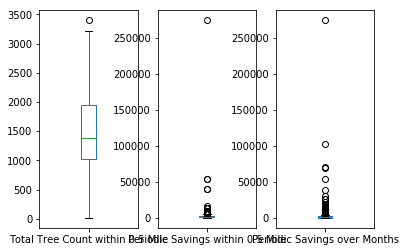

In [30]:
prediction_table.plot(kind = 'box', subplots = True, layout = (1,3), sharex = False, sharey = False)
plt.show() #what's that outlier in our savings? 

In [31]:
X1 = prediction_table[['Periodic Savings within 0.5 Mile','Total Tree Count within 0.5 Mile']].values
Y1 = prediction_table['Periodic Savings over Months']

In [32]:
model1 = LinearRegression()
model1.fit(X1, Y1)
cross_val_score(model1, X1, Y1, cv=3, scoring='neg_mean_absolute_error').mean()

-2416.0495170359877

In [33]:
model2 = BayesianRidge()
model2.fit(X1, Y1)
cross_val_score(model2, X1, Y1, cv=3, scoring='neg_mean_absolute_error').mean()

-2410.992224823291

In [34]:
model3 = SVR()
model3.fit(X1, Y1)
cross_val_score(model3, X1, Y1, cv=3, scoring='neg_mean_absolute_error').mean()

-2836.098137886751

In [35]:
import pickle
pickle.dump(model2, open('/tmp/model.pkl', 'wb'))

In [36]:
# Load model
from pickle import load
model = load(open('/tmp/model.pkl', 'rb'))  # !!! Replace dummy model with your model
model

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [37]:
url2 = 'https://raw.githubusercontent.com/wzmemo/NYC_Open_Data_Business_Savings/master/Testing_Data.csv'
testing_table = pd.read_csv(url2)

In [38]:
testing_table = testing_table.drop(['Unnamed: 0'], axis = 1)

In [39]:
X = testing_table[['Total Tree Count within 0.5 Mile', 'Periodic Savings within 0.5 Mile']].values
y = model.predict(X)
y

array([695.90254332, -30.41407771, 439.4542031 ])

In [40]:
testing_table['Periodic Savings over Months'] = y
testing_table

,Address,Total Tree Count within 0.5 Mile,Periodic Savings within 0.5 Mile,Periodic Savings over Months
0,43-23 35th Street,683,1423.931818,695.902543
1,141 Lake Avenue,21,336.525000,-30.414078
2,14-10 123rd Street,447,1079.380000,439.454203


## Render Table

In [41]:
# Save file to target folder to include it in the result download
target_path = target_folder + '/a.csv'
testing_table.to_csv(target_path, index=False)
print(f'a_table_path = {target_path}')  # Print table_path to render table

a_table_path = /tmp/a.csv


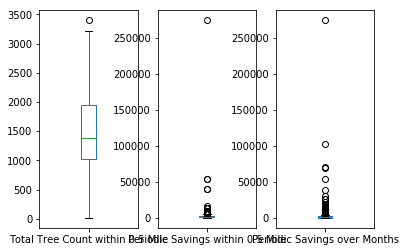

In [42]:
# A step further: 
prediction_table.plot(kind = 'box', subplots = True, layout = (1,3), sharex = False, sharey = False)
plt.show() #what's are outliers in our savings? 

## This is the end of the workbook :)